# Machine learning model

In this notebook we will train, tune, test and deploy a machine learning model for lifetime revenue forecasting using SageMaker.

The general steps are:

1. Prepare the data
2. Initial model
3. Hyperparameter tuning
4. Retraining the model
5. Batch inference
6. Performance evaluation
7. Model deployment

In [28]:
import io
import os
import gc
from datetime import datetime
import json
from urllib.parse import urlparse

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
sns.set()
pd.set_option("max_columns", 99)

import awswrangler as wr
from sagemaker.xgboost.estimator import XGBoost
import sagemaker
import boto3

def read_parquet_s3(bucket, filepath):
    buffer = io.BytesIO()
    s3 = boto3.resource('s3')
    obj = s3.Object(bucket, filepath)
    obj.download_fileobj(buffer)
    return pd.read_parquet(buffer)

In [18]:
#!python3 -m pip install awswrangler

## 1. Preparing the data

In order to train our model, we need to provide data in a specific format in S3.

In [37]:
### build training set
train = read_parquet_s3("capstone-transaction-data",
                        "processed_data/train_features.parquet")
train_target = read_parquet_s3("capstone-transaction-data",
                               "preprocessed_data/train_target.parquet")
train = train.merge(train_target, on="id", how="left")
train["purchaseamount_90d"].fillna(0, inplace=True)

# build test set
test = read_parquet_s3("capstone-transaction-data",
                       "processed_data/test_features.parquet")
test_target = read_parquet_s3("capstone-transaction-data",
                              "preprocessed_data/test_target.parquet")
test = test.merge(test_target, on="id", how="left")
test["purchaseamount_90d"].fillna(0, inplace=True)

print(train.shape)
print(test.shape)
train.head()

(288081, 34)
(305007, 34)


,id,num_unique_date,max_transaction_amount,sum_amount,avg_transaction_amount,days_since_last_transaction,days_since_first_transaction,avg_daily_amount,unique_dates_to_days,unique_dates_180d,transactions_count_180d,purchase_amount_sum_180d,avg_transaction_amount_180d,purchasequantity_sum_180d,time_weighted_amount_180d,unique_dates_90d,transactions_count_90d,purchase_amount_sum_90d,avg_transaction_amount_90d,purchasequantity_sum_90d,time_weighted_amount_90d,unique_dates_60d,transactions_count_60d,purchase_amount_sum_60d,avg_transaction_amount_60d,purchasequantity_sum_60d,time_weighted_amount_60d,unique_dates_30d,transactions_count_30d,purchase_amount_sum_30d,avg_transaction_amount_30d,purchasequantity_sum_30d,time_weighted_amount_30d,purchaseamount_90d
0,12262064,120,65.959999,2295.729980,4.114212,1,213,10.778075,0.563380,109.0,524.0,2132.280029,4.069237,609.0,538.865601,54.0,267.0,1055.380005,3.952734,290.0,319.114532,37.0,185.0,749.809998,4.053027,201.0,249.026154,19.0,93.0,337.389984,3.627849,102.0,140.975647,838.989990
1,12277270,93,24.980000,3601.310059,5.789887,2,210,17.149096,0.442857,81.0,539.0,3129.820068,5.806716,623.0,840.181580,38.0,262.0,1507.849976,5.755153,310.0,509.219116,24.0,188.0,1091.979980,5.808404,226.0,413.054291,12.0,116.0,660.409973,5.693190,144.0,299.235992,1505.689941
2,12332190,49,164.899994,1416.559937,5.169927,0,210,6.745523,0.233333,45.0,259.0,1348.000000,5.204633,328.0,347.427277,27.0,153.0,878.700012,5.743137,199.0,250.572433,15.0,107.0,704.510010,6.584206,141.0,210.490936,6.0,15.0,67.959999,4.530667,20.0,42.900917,1084.780029
3,12524696,70,21.990000,1581.670044,3.886167,3,213,7.425681,0.328638,61.0,368.0,1440.270020,3.913777,463.0,347.924866,27.0,170.0,689.890015,4.058177,214.0,195.126587,16.0,103.0,396.540009,3.849903,137.0,127.830322,8.0,57.0,242.279999,4.250526,74.0,88.039108,871.130005
4,12682470,73,36.990002,1578.010010,4.347135,3,213,7.408498,0.342723,63.0,278.0,1268.130005,4.561619,325.0,308.362732,30.0,112.0,546.119995,4.876071,134.0,161.810654,22.0,61.0,304.299988,4.988524,70.0,106.956429,13.0,41.0,196.849991,4.801219,48.0,78.548553,1113.880005


In [38]:
# fixing infinite and nans
not_num = train.isin([np.inf, -np.inf]).sum()
not_num[not_num > 0]

avg_daily_amount        126
unique_dates_to_days    126
dtype: int64

In [39]:
# replace for a special value (-1)
train.replace(np.inf, -1, inplace=True)
test.replace(np.inf, -1, inplace=True)

### Spliting in train, validation and test samples

The validation set is a 10% random sample from the train set, while the test set is an out-of-time sample. The validation set will be used for hyperparameter tunning and feature selection, while the out-of-time sample (test) is used only for our final results. In this way we are preventing overfitting and selection bias.

In [40]:
drop = ["id", "sum_amount", "num_unique_date", "purchaseamount_90d"]
features = [f for f in train.columns if f not in drop]
target = "purchaseamount_90d"

train, valid = train_test_split(train, test_size=0.1, random_state=0)
print(train.shape, valid.shape, test.shape)

(259272, 34) (28809, 34) (305007, 34)


SageMaker's algorithms expects a csv file as input with the first column being the target variable and the remaining columns as features. This csv file must not have a header nor index.

In [61]:
session = sagemaker.Session()
bucket = session.default_bucket()
role = sagemaker.get_execution_role()
train_path = "s3://{}/{}/{}".format(bucket, "datasets", "train.csv")
valid_path = "s3://{}/{}/{}".format(bucket, "datasets", "valid.csv")
test_path = "s3://{}/{}/{}".format(bucket, "datasets", "test.csv")

In [42]:
cols = [target] + features
wr.s3.to_csv(df=train[cols], path=train_path, header=False, index=False)
wr.s3.to_csv(df=valid[cols], path=valid_path, header=False, index=False)
wr.s3.to_csv(df=test[cols],  path=test_path,  header=False, index=False)

{'paths': ['s3://sagemaker-us-east-2-165065549497/datasets/test.csv'],
 'partitions_values': {}}

## 2. Initial model

As mentioned in the Baseline notebook, we will be using the Root Mean Squared Log Error (RMSLE) to evaluate our model. This metric has some properties that are aligned with our business problem as dicussed in the previous notebook. In order to do that, we need to provide a custom training script since this metric is not supported by the built-in version of SageMaker's XGBoost.

In [44]:
hyperparams = {
    "max_depth": "5",
    "eta": "0.1",
    "gamma": "6",
    "min_child_weight": "6",
    "subsample": "0.7",
    "alpha": "0",
    "num_round": "100",
    "verbosity": "2",
    "objective": "reg:squaredlogerror",
    "eval_metric_1": "rmsle",
    "eval_metric_2": "rmse",
}

output_path = "s3://{}/{}/output".format(bucket, "xgb_results")

# construct a xgb estimator from custom script
xgb_estimator = XGBoost(
    entry_point="xgb/xgb_train.py",
    framework_version="1.3-1",
    hyperparameters=hyperparams,
    role=role,
    instance_count=1,
    instance_type="ml.m5.2xlarge",
    output_path=output_path,
)

# wrapper around the location of our train and validation data
train_input = sagemaker.session.TrainingInput(train_path, content_type="csv")
valid_input = sagemaker.session.TrainingInput(valid_path, content_type="csv")

In [31]:
xgb_estimator.fit({"train": train_input, "validation": valid_input}, logs="None")


2021-08-01 01:16:33 Starting - Starting the training job
2021-08-01 01:16:35 Starting - Launching requested ML instances.........
2021-08-01 01:17:24 Starting - Preparing the instances for training............
2021-08-01 01:18:32 Downloading - Downloading input data..
2021-08-01 01:18:49 Training - Downloading the training image....
2021-08-01 01:19:10 Training - Training image download completed. Training in progress....
2021-08-01 01:19:31 Uploading - Uploading generated training model.
2021-08-01 01:19:40 Completed - Training job completed


## 3. Hyperparameter tuning

Using the validation sample to score our model, we are going to perform hyperparameter optimization for the XGBoost algorithm with the built-in SageMaker's Tuner. To search for the best hyperparameters, SageMaker is using a Bayesian approach within this algorithm.

Currently, this estimator does not support custom metrics for HPO due to an issue with the current container (as described [here](https://github.com/aws/sagemaker-xgboost-container/issues/121)). Therefore, we will perform the search using RMSE instead.

In [35]:
from sagemaker.tuner import IntegerParameter, ContinuousParameter, HyperparameterTuner

hyperparams_range = {
    'eta': ContinuousParameter(0.01, 0.1),
    'gamma': IntegerParameter(0, 10),
    'max_depth': IntegerParameter(3, 12),
    'min_child_weight': IntegerParameter(1, 10),
    'subsample': ContinuousParameter(0.5, 0.95),
    'lambda': ContinuousParameter(0, 2),
    'alpha': ContinuousParameter(0, 2),
    'num_round': IntegerParameter(50, 1500),
}

xgb_hyperparameter_tuner = HyperparameterTuner(estimator = xgb_estimator,
                                               objective_metric_name = 'validation:rmse',
                                               objective_type = 'Minimize',
                                               max_jobs = 100, # The total number of models to train
                                               max_parallel_jobs = 3, # The number of models to train in parallel
                                               #metric_definitions=metrics,
                                               hyperparameter_ranges = hyperparams_range)

In [ ]:
xgb_hyperparameter_tuner.fit({'train': train_input, 'validation': valid_input})
xgb_hyperparameter_tuner.wait()

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [37]:
#xgb_hyperparameter_tuner.best_training_job()
#xgb_attached = sagemaker.estimator.Estimator.attach(xgb_hyperparameter_tuner.best_training_job())

'sagemaker-xgboost-210801-0153-026-5af798c4'

## 4. Retraining the model

Now we fit the model with the best hyperparameters

In [45]:
hyperparams = {
    "max_depth": "6",
    "eta": "0.03017362",
    "gamma": "2",
    "min_child_weight": "1",
    "subsample": "1",
    "alpha": "0.05045427",
    "objective": "reg:squaredlogerror",
    "num_round": "1500",
    "verbosity": "2",
    "objective": "reg:squaredlogerror",
    "eval_metric_1": "rmsle",
    "eval_metric_2": "rmse",
}

output_path = "s3://{}/{}/output".format(bucket, "xgb_results_02")

# construct a xgb estimator from custom script
xgb_estimator = XGBoost(
    entry_point="xgb/xgb_train.py",
    framework_version="1.3-1",
    hyperparameters=hyperparams,
    role=role,
    instance_count=1,
    instance_type="ml.m5.xlarge",
    output_path=output_path,
)
xgb_estimator.fit({"train": train_input, "validation": valid_input}, logs="None")


2021-08-02 16:54:19 Starting - Starting the training job
2021-08-02 16:54:21 Starting - Launching requested ML instances............
2021-08-02 16:55:26 Starting - Preparing the instances for training................
2021-08-02 16:56:51 Downloading - Downloading input data...
2021-08-02 16:57:11 Training - Downloading the training image...
2021-08-02 16:57:32 Training - Training image download completed. Training in progress.........................................
2021-08-02 17:01:00 Uploading - Uploading generated training model.
2021-08-02 17:01:09 Completed - Training job completed


## 5. Batch transform job

Now that we have a trained model, we can make predictions for the three samples (train, validation and out-of-time) to evaluate our model. To do this we will make use of SageMaker's Batch Transform functionality. To start with, we need to build a transformer object from our fited model.

In [66]:
xgb_estimator = sagemaker.estimator.Estimator.attach("sagemaker-xgboost-2021-08-02-16-54-19-126")


2021-08-02 17:01:24 Starting - Preparing the instances for training
2021-08-02 17:01:24 Downloading - Downloading input data
2021-08-02 17:01:24 Training - Training image download completed. Training in progress.
2021-08-02 17:01:24 Uploading - Uploading generated training model
2021-08-02 17:01:24 Completed - Training job completed


In [78]:
train_path_no_target = "s3://{}/{}/{}".format(bucket, "datasets", "train_no_target.csv")
valid_path_no_target = "s3://{}/{}/{}".format(bucket, "datasets", "valid_no_target.csv")
test_path_no_target = "s3://{}/{}/{}".format(bucket, "datasets", "test_no_target.csv")
wr.s3.to_csv(df=train[features], path=train_path_no_target, header=False, index=False)
wr.s3.to_csv(df=valid[features], path=valid_path_no_target, header=False, index=False)
wr.s3.to_csv(df=test[features],  path=test_path_no_target,  header=False, index=False)

In [83]:
output_path_pred = "s3://{}/{}".format(bucket, "predictions")
xgb_transformer = xgb_estimator.transformer(1, "ml.m5.large", accept="text/csv",
                                            strategy="MultiRecord", output_path=output_path_pred)

In [84]:
# start a transform job
xgb_transformer.transform(train_path_no_target, data_type="S3Prefix",
                          split_type="Line", content_type="text/csv", logs=False)
xgb_transformer.wait()

.....................................................!
[2021-08-02:20:08:02:INFO] No GPUs detected (normal if no gpus installed)
[2021-08-02:20:08:02:INFO] No GPUs detected (normal if no gpus installed)
[2021-08-02:20:08:02:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;

worker_rlimit_nofile 4096;

events {
  worker_connections 2048;
}

[2021-08-02:20:08:02:INFO] No GPUs detected (normal if no gpus installed)
[2021-08-02:20:08:02:INFO] No GPUs detected (normal if no gpus installed)
[2021-08-02:20:08:02:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;

worker_rlimit_nofile 4096;

events {
  worker_connections 2048;
}

http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;

  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }

  server {
    listen 8080 deferred;
    client_max_body_size 0;

    keepalive_timeout 3;


In [85]:
xgb_transformer.transform(valid_path_no_target, data_type="S3Prefix",
                          split_type="Line", content_type="text/csv", logs=False)
xgb_transformer.wait()

....................................................!
[2021-08-02:20:27:19:INFO] No GPUs detected (normal if no gpus installed)
[2021-08-02:20:27:19:INFO] No GPUs detected (normal if no gpus installed)
[2021-08-02:20:27:19:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;

worker_rlimit_nofile 4096;

events {
  worker_connections 2048;
}

http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;

  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }

  server {
    listen 8080 deferred;
    client_max_body_size 0;

    keepalive_timeout 3;

    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }

    location / {
      return 404 "{}";
    }

  }
}


[2021-08-02 20:27:2

In [86]:
xgb_transformer.transform(test_path_no_target, data_type="S3Prefix",
                          split_type="Line", content_type="text/csv", logs=False)
xgb_transformer.wait()

.........................................................!
[2021-08-02:20:31:41:INFO] No GPUs detected (normal if no gpus installed)
[2021-08-02:20:31:41:INFO] No GPUs detected (normal if no gpus installed)
[2021-08-02:20:31:41:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;

worker_rlimit_nofile 4096;

events {
  worker_connections 2048;
}

[2021-08-02:20:31:41:INFO] No GPUs detected (normal if no gpus installed)
[2021-08-02:20:31:41:INFO] No GPUs detected (normal if no gpus installed)
[2021-08-02:20:31:41:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;

worker_rlimit_nofile 4096;

events {
  worker_connections 2048;
}

http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;

  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }

  server {
    listen 8080 deferred;
    client_max_body_size 0;

    keepalive_timeout

The inference is done and the output files are writen to the default bucket. Now we need to load these files and compare against the actual target:

In [87]:
def get_csv_output_from_s3(s3uri, file_name):
    parsed_url = urlparse(s3uri)
    bucket_name = parsed_url.netloc
    prefix = parsed_url.path[1:]
    s3 = boto3.resource("s3")
    obj = s3.Object(bucket_name, "{}/{}".format(prefix, file_name))
    return obj.get()["Body"].read().decode("utf-8")

In [95]:
train_output = get_csv_output_from_s3(output_path_pred, "train_no_target.csv.out")
valid_output = get_csv_output_from_s3(output_path_pred, "valid_no_target.csv.out")
test_output = get_csv_output_from_s3(output_path_pred, "test_no_target.csv.out")
train_predictions = pd.read_csv(io.StringIO(train_output), sep=",", header=None, squeeze=True)
valid_predictions = pd.read_csv(io.StringIO(valid_output), sep=",", header=None, squeeze=True)
test_predictions = pd.read_csv(io.StringIO(test_output),  sep=",", header=None, squeeze=True)
print(train_predictions.shape, valid_predictions.shape, test_predictions.shape)

(259272,) (28809,) (305007,)


In [99]:
train.purchaseamount_90d

187650      94.309998
167886     708.890015
251411     663.369995
155633    1254.760010
41853      581.130005
             ...     
211543     199.470001
86293     1998.349976
122579     298.579987
152315     426.459991
117952    1090.209961
Name: purchaseamount_90d, Length: 259272, dtype: float32

In [100]:
train_predictions

0         420.060089
1         476.577271
2         787.423401
3         843.479614
4         855.192200
             ...    
259267    803.998108
259268    858.120483
259269    499.392609
259270    535.215698
259271    811.877563
Name: 0, Length: 259272, dtype: float64

## 6. Model performance

In [111]:
from sklearn.metrics import mean_squared_log_error, mean_squared_error

def get_score(y_true, y_pred, metric="rmsle"):
    assert len(y_true) == len(y_pred)
    if metric == "rmsle":
        return np.sqrt(mean_squared_log_error(y_true, y_pred))
    elif metric == "rmse":
        return np.sqrt(mean_squared_error(y_true, y_pred))
    else:
        raise ValueError("Metric {} not available".format(metric))

train_score = get_score(train.purchaseamount_90d, train_predictions, "rmsle")
valid_score = get_score(valid.purchaseamount_90d, valid_predictions, "rmsle")
test_score = get_score(test.purchaseamount_90d, test_predictions, "rmsle")
print("RMSLE - train: {:.4f}, valid: {:.4f}, test: {:.4f}".format(train_score, valid_score, test_score))

RMSLE - train: 0.7325, valid: 0.7339, test: 0.7153


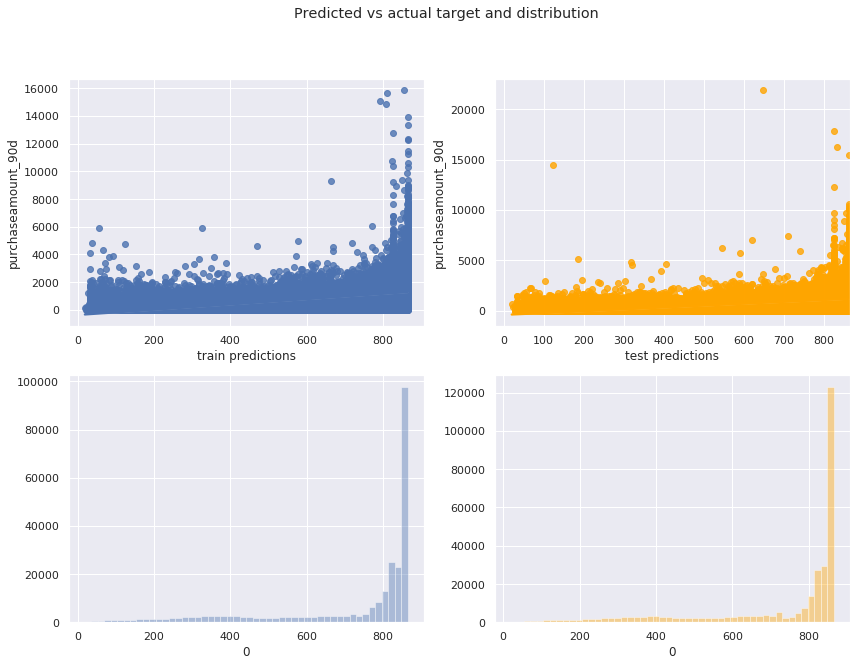

In [112]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()
fig.suptitle('Predicted vs actual target and distribution')
sns.regplot(x=train_predictions, y=train.purchaseamount_90d, ax=axes[0])
sns.regplot(x=test_predictions, y=test.purchaseamount_90d,
            ax=axes[1], color="orange")
sns.distplot(train_predictions, kde=False, ax=axes[2])
sns.distplot(test_predictions, kde=False, ax=axes[3], color="orange")
_ = axes[0].set(xlabel='train predictions')
_ = axes[1].set(xlabel='test predictions')

Predictions are highly concentrated around the average transaction value for 90 days, indicating a high bias. In other words, with the current features, the xgboost is not being able to make good predictions. Consequently, this model has a lot of room to improve even further.

## 7. Deploy the model

Now we can use the deploy method to create an endpoint api for making predictions with our model. This method returns a XGBoostPredictor object, which accepts libsvm and csv data as input. The default serializer is the libsvm, so we need to pass a CSVSerializer object to this method.

In [113]:
predictor = xgb_estimator.deploy(
    initial_instance_count=1, instance_type="ml.t2.medium",
    serializer=sagemaker.serializers.CSVSerializer(content_type='text/csv')
)

-----------!

In [114]:
# Testing the endpoint
train.reset_index().loc[:10, features].to_csv("sample_data.csv", index=False, header=False)

In [115]:
with open("sample_data.csv", "r") as f:
    payload = f.read()

In [116]:
train_pred = predictor.predict(payload)
train_pred

b'420.0600891113281,476.5772705078125,787.4234008789062,843.4796142578125,855.1921997070312,814.732421875,864.5066528320312,816.8322143554688,839.1279907226562,831.0686645507812,546.3779296875'

### Points to improve (Work in Progress!)

- Better feature engineering
- More hyperparameter tuning
- Test the model with log target
- Building a dashboard